In [135]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# GRU + Meta data DAG model 


**Sequence Data Version:** `v6.1`


**Meta Data Version:**: `v2`



In [138]:
import numpy as np
import pandas as pd

import sys
sys.path.append('../')

from tqdm import tqdm
from config import interim_data_dir, raw_data_dir

from src.utils import read_shapefile

## Load Datasets

In [139]:
import numpy as np
import pandas as pd

from tqdm import tqdm
from config import interim_data_dir, raw_data_dir

from src.utils import read_shapefile

from config import processed_data_dir


# Sequential Data
dataset_version = 'v7.1'

train_features_df = pd.read_csv(processed_data_dir/'VI_datasets'/dataset_version/'train.csv', index_col=0)
test_features_df = pd.read_csv(processed_data_dir/'VI_datasets'/dataset_version/'test.csv', index_col=0)
class_weight = 1-train_features_df.y.value_counts(normalize=True)

# Meta data
metadata_version = 'v2'
train_meta_df = pd.read_csv(processed_data_dir / 'meta_data' / metadata_version / "train_scaled.csv", index_col=0)
test_meta_df = pd.read_csv(processed_data_dir / 'meta_data' / metadata_version / "test_scaled.csv", index_col=0)

In [142]:
nans = lambda df: df[df.isnull().any(axis=1)]

nans(train_features_df).shape

(1175, 113)

In [143]:
nans(test_features_df).shape

(476, 112)

## Process Data

### Sequential Data

In [144]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def impute_nan_inf(df):
    """
    Impute bad values (nan and inf) using
    the median of that feature on that time stamp
    for all farms
    
    TODO: This can be improved
    """
    
    # replace all nans variants with np.nan
    df = df.replace([np.nan, None, np.inf, -np.inf], 0)
#     df = df.replace([np.nan, None, np.inf, -np.inf], np.nan)

    # replace all nans with the median value of all farms on that timestamp
#     for ts, ts_df in df.groupby('time'):
#         df.loc[ts_df.index] = ts_df.fillna(ts_df.median())
        
    return df

In [145]:
train_features_df = impute_nan_inf(train_features_df)
test_features_df = impute_nan_inf(test_features_df)

In [146]:
train_features_df.head()

,farm_id,time,ndvi_mean,ndvi_median,ndvi_min,ndvi_max,ndvi_std,cvi_mean,cvi_median,cvi_min,...,band_11_median,band_11_min,band_11_max,band_11_std,band_12_mean,band_12_median,band_12_min,band_12_max,band_12_std,y
0,1,2017-01-01,0.671766,0.692653,0.454174,0.745895,0.065668,0.000000,0.947159,0.001221,...,0.0,0.0,2427.0,1033.316114,496.128571,0.0,0.0,1422.0,526.755647,Vineyard
1,1,2017-01-31,0.718396,0.729027,0.586915,0.781602,0.046242,0.000000,1.052384,0.047159,...,0.0,0.0,2315.0,1039.211662,521.650000,0.0,0.0,1382.0,549.157835,Vineyard
2,1,2017-02-10,0.746055,0.755768,0.633239,0.798810,0.038175,3.438654,3.456926,2.854073,...,0.0,0.0,2482.0,1155.934793,508.700000,0.0,0.0,1282.0,533.618506,Vineyard
3,1,2017-03-12,0.668629,0.684211,0.514993,0.765019,0.065733,2.180335,0.865489,0.003610,...,0.0,0.0,2011.0,938.965428,466.950000,0.0,0.0,1187.0,490.728297,Vineyard
4,1,2017-03-22,0.659258,0.673052,0.511155,0.747845,0.055294,2.783775,1.226074,0.010952,...,0.0,0.0,1981.0,911.059519,433.728571,0.0,0.0,1105.0,455.879587,Vineyard


In [147]:
# Make copies to compare before / after normalization
train_copy = train_features_df.copy()
test_copy = test_features_df.copy()

times = train_features_df['time'].unique()

feature_cols = [col for col in test_features_df.columns if col not in ['farm_id','time']]

for i, ts in enumerate(times):
    
    train_ts_df = train_copy[train_copy.time == ts]
    test_ts_df = test_copy[test_copy.time == ts]
    
    if i == 0:
        scaler = StandardScaler()
        scaler.fit(train_ts_df[feature_cols])

#     scaler = StandardScaler()
#     scaler.fit(train_ts_df[feature_cols])
    
    train_features_df.loc[train_ts_df.index, feature_cols] = scaler.transform(train_ts_df[feature_cols])
    test_features_df.loc[test_ts_df.index, feature_cols] = scaler.transform(test_ts_df[feature_cols])
    

In [153]:
def transform_dataset(features_df):
    """
    Create a data array in the shape (n_ids, n_time, n_features)
    
    If it is the training set, also return dictionary mapping index
    in dataset to correct label.
    
    """
    
    n_ids = features_df.farm_id.nunique()

    feature_cols = [col for col in features_df.columns if col not in ['farm_id','y','time']]
    
    n_features = len(feature_cols)

    data = np.ndarray((n_ids, 11, n_features))
    
    classes = {}
    for i, (farm_id, farm_df) in enumerate(features_df.groupby(['farm_id'])):

        data[i,:,:] = farm_df[feature_cols].values
        
        if 'y' in features_df.columns:
            c = farm_df['y'].unique()
            classes[i] = c[0]
            
    return data, classes
    
train_data, train_labels_dict = transform_dataset(train_features_df)
test_data, _ = transform_dataset(test_features_df)

print('Sequential Datasets:')
print('Train data:\t\t',train_data.shape)
print('Test data:\t\t',test_data.shape)

Sequential Datasets:
Train data:		 (2494, 11, 110)
Test data:		 (1074, 11, 110)


### Meta Data

In [154]:
train_meta_df.head()

,Area,Subregion_3.0,Subregion_1.0,Subregion_4.0,Subregion_2.0,Subregion_5.0,Subregion_6.0,Subregion_0.0,Subregion_7.0,lat,...,distance_4,Cotton,Dates,Grass,Lucern,Maize,Pecan,Vacant,Vineyard,"Vineyard & Pecan (""Intercrop"")"
Field_Id,,,,,,,,,,,,,,,,,,,,,
1,-0.589766,1,0,0,0,0,0,0,0,1.739183,...,1.299743,-0.364116,-0.110013,-0.387037,-0.866913,-0.555023,2.329529,-0.635723,2,1.738146
2,-0.157671,1,0,0,0,0,0,0,0,1.761063,...,-0.304332,-0.364116,-0.110013,-0.387037,-0.043890,-0.555023,-0.403873,-0.635723,3,1.738146
3,-0.527917,1,0,0,0,0,0,0,0,1.753355,...,-0.061299,0.856456,-0.110013,-0.387037,-0.866913,-0.555023,0.962828,-0.635723,2,1.738146
4,-0.439169,1,0,0,0,0,0,0,0,1.764898,...,0.222124,0.856456,-0.110013,-0.387037,-0.043890,-0.555023,0.962828,-0.635723,1,1.738146
7,1.145875,1,0,0,0,0,0,0,0,1.765042,...,0.031368,-0.364116,-0.110013,-0.387037,-0.043890,-0.555023,0.962828,-0.635723,3,-0.316326


In [155]:
train_meta_data = train_meta_df.values
test_meta_data = test_meta_df.values

print('Meta Data Shape: ')
print('Train:\t',train_meta_data.shape)
print('Test:\t',test_meta_data.shape)

Meta Data Shape: 
Train:	 (2494, 30)
Test:	 (1074, 30)


## Start Modelling Process

### Create validation set

In [156]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

seed = 420

# Copy for later
data = train_data.copy()

train_labels = list(train_labels_dict.values())
train_indexes = list(train_labels_dict.keys())

train_idx, val_idx, train_labels, val_labels = train_test_split(train_indexes, 
                                                                train_labels, 
                                                                stratify=train_labels, 
                                                                test_size=0.1, 
                                                                random_state=seed)

le = LabelEncoder()
train_labels_enc = le.fit_transform(np.array(train_labels).reshape(-1,1))
val_labels_enc = le.transform(np.array(val_labels).reshape(-1,1))

train_data = data[train_idx,:, :]
val_data = data[val_idx,:, :]

# Split Meta data into train and val
train_data_meta = train_meta_data[train_idx,:]
val_data_meta = train_meta_data[val_idx,:]

print('Split Dataset Shapes:')
print('train data:\t Seq: {}\t Meta: {}'.format(train_data.shape, train_data_meta.shape))
print('train data:\t Seq: {}\t Meta: {}'.format(val_data.shape, val_data_meta.shape))

Split Dataset Shapes:
train data:	 Seq: (2244, 11, 110)	 Meta: (2244, 30)
train data:	 Seq: (250, 11, 110)	 Meta: (250, 30)


### Create model

In [157]:
import tensorflow as tf
import keras
from keras import models, layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from src.visualization.tf_viz import PlotLosses

from keras.layers import Input, Dense
from keras.models import Model

def get_dag_model(n_ts_features, n_meta_features):
    
    # Get the model
    GRU_cells = 8
    recurrent_activation = 'hard_sigmoid'
    recurrent_dropout = 0.6093571771811351


    # Temporal Model
    input_timeseries = Input(shape=(11,n_ts_features,))

    x = layers.Dense(64, activation='relu')(input_timeseries)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.GRU(GRU_cells, 
                         return_sequences=True,
                         recurrent_activation=recurrent_activation, 
                         recurrent_dropout=recurrent_dropout)(x)
    x = layers.GRU(GRU_cells, 
                         return_sequences=True,
                         recurrent_activation=recurrent_activation, 
                         recurrent_dropout=recurrent_dropout)(x)
    x = layers.GRU(GRU_cells, 
                         return_sequences=True,
                         recurrent_activation=recurrent_activation, 
                         recurrent_dropout=recurrent_dropout)(x)
    x = layers.Flatten()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    
    # Meta Model
    input_meta_data = Input(shape=(n_meta_features,))

    y = layers.Dense(64, activation='relu',)(input_meta_data)
    y = layers.BatchNormalization()(y)
    y = layers.Dropout(0.2)(y)
    y = layers.Dense(16, activation='relu')(y)
    y = layers.Dropout(0.1)(y)
    y = layers.BatchNormalization()(y)

    bottleneck = layers.concatenate([x,y])
    bottleneck = layers.Dense(50, activation='relu')(bottleneck)
    bottleneck = layers.Dropout(0.3)(bottleneck)
    bottleneck = layers.BatchNormalization()(bottleneck)
    bottleneck = layers.Dense(9, activation='softmax')(bottleneck)

    model = Model(inputs=[input_timeseries,input_meta_data], outputs=bottleneck)
    
    return model

### Set modelling parameters

In [162]:
from src.models.clr_callback import CyclicLR
from keras.callbacks import ModelCheckpoint

from config import models_dir


# lr = 0.0005
lr=3e-4

# Choose optimizer
# optimizer = keras.optimizers.RMSprop(lr)
optimizer = keras.optimizers.Adam(lr)


plot_losses = PlotLosses()
es = EarlyStopping(monitor='val_loss', verbose=1, patience=100)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=30, verbose=1, factor=0.5, min_delta=0.001,)

f_checkpoint_val = str(models_dir / f'gru_dag_val_{dataset_version}.{metadata_version}.hdf5')
checkpoint = ModelCheckpoint(f_checkpoint_val, 
                             save_best_only=True, 
                             mode='min', 
                             monitor='val_loss')


# Combine Callbacks
callbacks = [
    plot_losses, 
    es, 
    reduce_lr,
    checkpoint
]

# Create model & compile
model = get_dag_model(train_data.shape[-1], train_data_meta.shape[-1])

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy')

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           (None, 11, 110)      0                                            
__________________________________________________________________________________________________
dense_103 (Dense)               (None, 11, 64)       7104        input_35[0][0]                   
__________________________________________________________________________________________________
batch_normalization_103 (BatchN (None, 11, 64)       256         dense_103[0][0]                  
__________________________________________________________________________________________________
dropout_103 (Dropout)           (None, 11, 64)       0           batch_normalization_103[0][0]    
__________________________________________________________________________________________________
dense_104 

## TRAIN!!

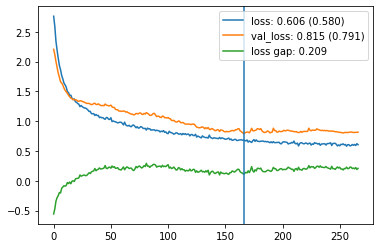

Epoch 00267: early stopping


In [163]:
batch_size = 64
epoch_size = 1000

model.fit([train_data, train_data_meta], 
          train_labels_enc,
          batch_size=batch_size,
          validation_data=([val_data, val_data_meta], val_labels_enc), 
          class_weight=class_weight,
          verbose=0,
          epochs=epoch_size, 
          callbacks=callbacks)

### Inspect best model performance

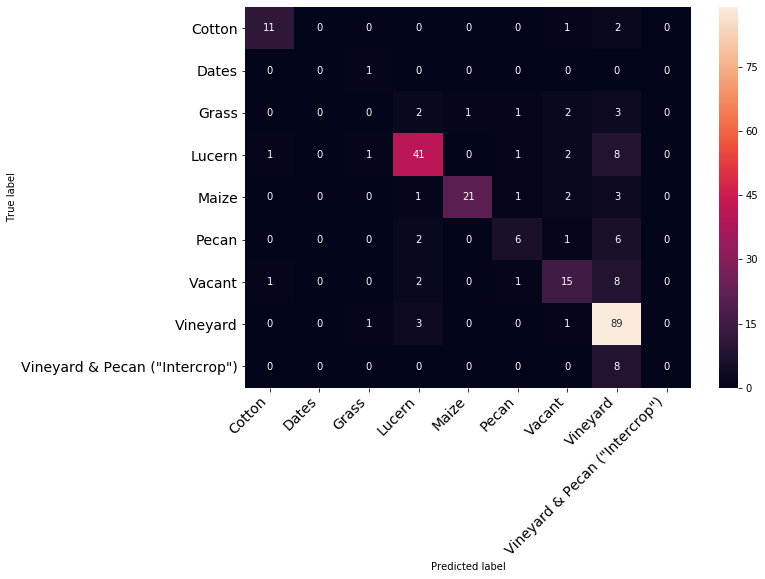

In [164]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from src.visualization.visualize import print_confusion_matrix

# Load best model
best_model = load_model(str(models_dir / f'gru_dag_val_{dataset_version}.{metadata_version}.hdf5'))

class_labels = pd.read_csv(raw_data_dir / 'crop_id_list.csv', index_col=0).sort_index().crop

val_probs = best_model.predict([val_data, val_data_meta])

val_preds = np.argmax(val_probs, axis=1)

cm = confusion_matrix(val_labels_enc, val_preds)
print_confusion_matrix(cm, class_names=class_labels);

In [17]:
from sklearn.metrics import classification_report

pd.DataFrame(classification_report(val_labels_enc, val_preds, output_dict=True))

,0,1,2,3,4,5,6,7,8,accuracy,macro avg,weighted avg
f1-score,0.947368,0.0,0.166667,0.857143,0.909091,0.489796,0.704918,0.892768,0.235294,0.817635,0.578116,0.797219
precision,0.964286,0.0,0.400000,0.845455,0.943396,0.600000,0.632353,0.840376,1.000000,0.817635,0.691763,0.810299
recall,0.931034,0.0,0.105263,0.869159,0.877193,0.413793,0.796296,0.952128,0.133333,0.817635,0.564244,0.817635
support,29.000000,1.0,19.000000,107.000000,57.000000,29.000000,54.000000,188.000000,15.000000,0.817635,499.000000,499.000000


In [104]:
pd.DataFrame(classification_report(val_labels_enc, val_preds, output_dict=True))

,0,1,2,3,4,5,6,7,8,accuracy,macro avg,weighted avg
f1-score,0.912281,0.0,0.370370,0.871560,0.872727,0.500000,0.661290,0.886076,0.333333,0.811623,0.600849,0.798171
precision,0.928571,0.0,0.625000,0.855856,0.905660,0.631579,0.585714,0.845411,1.000000,0.811623,0.708644,0.813395
recall,0.896552,0.0,0.263158,0.887850,0.842105,0.413793,0.759259,0.930851,0.200000,0.811623,0.577063,0.811623
support,29.000000,1.0,19.000000,107.000000,57.000000,29.000000,54.000000,188.000000,15.000000,0.811623,499.000000,499.000000


### Now on all data

In [105]:
all_data = np.vstack([train_data, val_data])
all_labels = np.array(list(train_labels_enc) + list(val_labels_enc))

all_data_meta = np.vstack([train_data_meta, val_data_meta])

class_weight = (1 - pd.Series(all_labels).value_counts(normalize=True)).to_dict()

In [106]:
from src.models.clr_callback import CyclicLR
from keras.callbacks import ModelCheckpoint

from config import models_dir

from keras.layers import Input, Dense
from keras.models import Model

lr = 0.00015

# Choose optimizer
optimizer = keras.optimizers.RMSprop(lr)
f_checkpoint = str(models_dir / f'gru_dag_{dataset_version}.{metadata_version}.hdf5')
checkpoint = ModelCheckpoint(f_checkpoint, 
                             save_best_only=True, 
                             mode='min', 
                             monitor='loss')
callbacks = [
    plot_losses, 
    checkpoint
]

model = get_dag_model(all_data.shape[-1], all_data_meta.shape[-1])

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy')

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           (None, 11, 110)      0                                            
__________________________________________________________________________________________________
dense_79 (Dense)                (None, 11, 64)       7104        input_27[0][0]                   
__________________________________________________________________________________________________
batch_normalization_79 (BatchNo (None, 11, 64)       256         dense_79[0][0]                   
__________________________________________________________________________________________________
dropout_79 (Dropout)            (None, 11, 64)       0           batch_normalization_79[0][0]     
__________________________________________________________________________________________________
dense_80 (

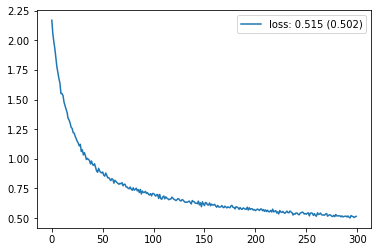

In [107]:
epochs=150

model.fit([all_data,all_data_meta], 
          all_labels,
          batch_size=batch_size,
          class_weight=class_weight,
          verbose=0,
          epochs=epochs, 
          callbacks=callbacks)

### Load Best Model

In [130]:
from keras.models import load_model

model = load_model(f_checkpoint)

In [131]:
f_checkpoint

'/Users/renier.botha/dev/personal/ds/zindi/farm-pin/models/gru_dag_v7.1.v2.hdf5'

## Make a submission

In [132]:
def make_sub(predictions, ids_list):
    
    sub_df = pd.read_csv(raw_data_dir / 'sample_submission_fixed.csv')

    new_sub = sub_df.copy().set_index('field_id')

    new_sub.loc[ids_list] = predictions
    
    return new_sub

predictions = model.predict([test_data, test_meta_data])
test_ids = sorted(list(test_features_df.farm_id.unique()))
sub_df = make_sub(predictions, test_ids)
sub_df.head()

,crop_id_1,crop_id_2,crop_id_3,crop_id_4,crop_id_5,crop_id_6,crop_id_7,crop_id_8,crop_id_9
field_id,,,,,,,,,
5,0.011898,0.012007,0.052161,0.042900,0.013288,0.444795,0.030655,0.239487,0.152809
6,0.012823,0.012498,0.065190,0.030010,0.012539,0.411136,0.031497,0.255756,0.168552
10,0.027403,0.013764,0.040464,0.029288,0.009732,0.153487,0.038201,0.614100,0.073561
18,0.019671,0.018248,0.033106,0.045447,0.014410,0.066321,0.037237,0.704918,0.060642
23,0.036023,0.016314,0.185708,0.041397,0.029915,0.119949,0.099726,0.393070,0.077897


### Save submission file

In [128]:
from config import subs_dir

fname = 'gru_dag_data_v7.2'
sub_df.to_csv(subs_dir / f'{fname}.csv')

### Save model architecture

In [129]:
with open(subs_dir / 'architectures' / f'{fname}.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))